# Smart Distribution Systems (B-KUL-H00P3A) 
Prof. Geert Deconinck

This exercise session will familiarize the students with basic concepts from machine learning and teach the students how these concepts can be used within power systems for forecasting.

The students will learn to:
* set up a machine learning environment, using state-of-the-art tools, such as keras, tensorflow and theano in Python;
* implement and train a two-layer neural network using Keras;
* use this neural network to make prediction about the wholesale electricity price.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import datetime
from sklearn.cross_validation import train_test_split, cross_val_predict, KFold
%matplotlib notebook

For more information on de pandas data frame see: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [2]:
data = pickle.load(open('electricity_prices_belgium.pkl', "rb"))

Usefull commands
* data.head(10) prints the first 10 samples
* data.tail(10) prints the last 10 samples
* data.$wind$ prints the collumn with label $wind$ 
* data.wind.plot plots the wind timeseries

# 1. Visualize the data

In [3]:
print data.head(10)
print data.tail(10)

                           belpex  solar    wind
2013-12-31 23:00:00+00:00   15.15    0.0  780.10
2013-12-31 23:00:00+00:00   15.15    0.0  780.10
2013-12-31 23:15:00+00:00   15.15    0.0  781.09
2013-12-31 23:30:00+00:00   15.15    0.0  793.82
2013-12-31 23:45:00+00:00   15.15    0.0  824.23
2014-01-01 00:00:00+00:00   12.96    0.0  818.43
2014-01-01 00:15:00+00:00   12.96    0.0  772.98
2014-01-01 00:30:00+00:00   12.96    0.0  730.92
2014-01-01 00:45:00+00:00   12.96    0.0  752.76
2014-01-01 01:00:00+00:00   12.09    0.0  802.97
                           belpex  solar    wind
2016-12-31 20:30:00+00:00   36.00    0.0  380.95
2016-12-31 20:45:00+00:00   36.00    0.0  385.43
2016-12-31 21:00:00+00:00   35.00    0.0  359.76
2016-12-31 21:15:00+00:00   35.00    0.0  340.07
2016-12-31 21:30:00+00:00   35.00    0.0  335.37
2016-12-31 21:45:00+00:00   35.00    0.0  330.47
2016-12-31 22:00:00+00:00   34.94    0.0  347.93
2016-12-31 22:15:00+00:00   34.94    0.0  375.27
2016-12-31 22:30:00+

Create a plot of the different collums using matplotlib.

Plotting with matplotlib.pyplot is very similar to plotting in matlab. Some key commands:
* <b>plt.figure()</b>: creates a new, blank figure. This changes the current graph and axis to the newly created ones. All commands applied hereafter will be applied to the new, current figure.
* <b>plt.show()</b>: show the figure. If you don't execute this command, no figure will show.
* For more commands, see http://matplotlib.org/users/pyplot_tutorial.html

<IPython.core.display.Javascript object>


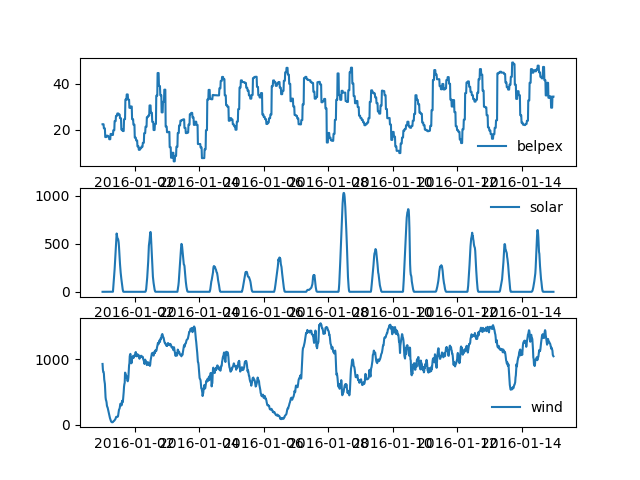

In [4]:
start = datetime.datetime(2016, 1, 1, 0, 0)
end = datetime.datetime(2016, 1, 14, 23, 45)

plt.figure()
plt.subplot(311)
plt.plot(data.belpex[start:end], label='belpex')
plt.legend(frameon=False)
plt.subplot(312)
plt.plot(data.solar[start:end], label='solar')
plt.legend(frameon=False)
plt.subplot(313)
plt.plot(data.wind[start:end], label='wind')
plt.legend(frameon=False)
plt.show()

<IPython.core.display.Javascript object>


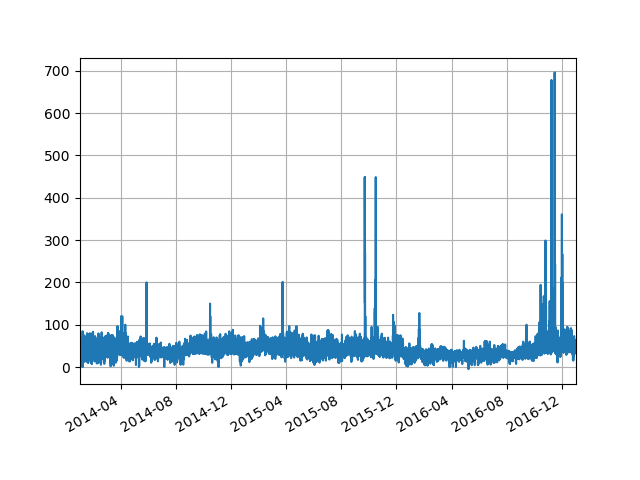

In [5]:
plt.figure()
data.belpex.plot(grid=True)
plt.show()

# 2. Clean the data by removing outliers

Clue: Use a generic method from statistics that is independent of the timeseries

In [6]:
mean = data.belpex.mean()
std = data.belpex.std()
n_std = 5
data['belpex'][(data.belpex >= mean + n_std*std)] = mean + n_std*std 



<IPython.core.display.Javascript object>


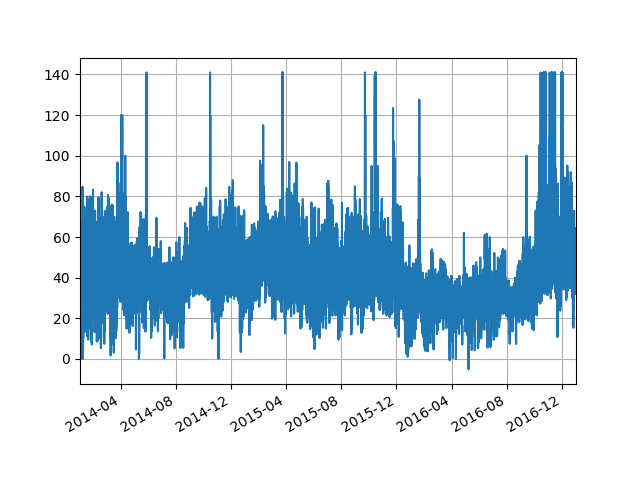

In [7]:
plt.figure()
data.belpex.plot(grid=True)
plt.show()

# 3. Create boxplot

grouped by
* days in the week
* months
* hours
* years

http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html

A pandas dataframe has a table like structure. The very first column in the table contains the indices, uniquely identifying each row in the table. These indices can be a set of integers, or like in this case, a set of timestamps, points in time when the specified data was realised.

'data.index' will return all timestamps of the dataset as an array. These timestamps have certain attributes available. For a reference, see:
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html

Below, attributes of the datetime indices are stored in a new column of the table. This allows us to create box plots grouped by these attributes, such as day of the week, hour, etc.

In [8]:
data['week_days']=data.index.weekday
data['month_days']=data.index.day
data['hours']=data.index.hour
data['months']=data.index.month

data.boxplot(column='belpex', by='month_days')

<IPython.core.display.Javascript object>

In [9]:
data.boxplot(column='belpex', by='week_days')

<IPython.core.display.Javascript object>

In [10]:
data.boxplot(column='belpex', by='hours')

<IPython.core.display.Javascript object>

In [11]:
data.boxplot(column='belpex', by='months')

<IPython.core.display.Javascript object>

Finally, <b>give it a try yourself</b>. Make a boxplot grouped by the year.

# 4. Check for randomness in the time series using an autocorrelation plot

This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. 

The autocorrelation is the correlation of a timeseries with a delayed copy of itself and is given by:
\begin{equation}
R(\tau) = \frac{E[(X_{t}-\mu)(X_{t+\tau}-\mu)]}{\sigma^2}
\end{equation}
where $X_t$ is the time series and $\tau$ is the time-lag.

How to make an autocorrelation plot using pandas in python:
http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-autocorrelation

In [12]:
# Autocorrelation
lags = np.arange(1, 96*10)
acors = []
for lag in lags:
    acors.append(data.belpex.autocorr(lag))
plt.figure()
plt.plot(lags/4/24.0, acors)
plt.xlabel('Time lag in days')
plt.grid(True)

<IPython.core.display.Javascript object>

# 5. Create a scatter matrix 

<b>Why use a scatter plot matrix?</b>

You have three types of data:
* electricity price $p$
* solar generation $s$
* wind generation $w$

For certain moments in time, we have three data points. This means we could think of our dataset as points in a four-dimensional space:
$$\begin{Bmatrix}t\\p\\s\\w\end{Bmatrix}$$

Unless you can think of your dataset in four dimensions, let's make it a bit easier. First, we strip away the time dimension. This leaves us with a more dense three-dimensional space containing all our samples. Still, we don't like to think in three dimensions. So let's just try all possible pairs of the remaining dimensions.

We visualize each pair with a scatter plot. A scatter plot is simply a graph with dots, which are not connected. Hence, we get a matrix of scatter plots, a scatter matrix.

We do all of this to explore our dataset, and find relationships in our data. For example, if the 'price vs solar generation' scatter plot shows dots centered around a straight line, then we can conclude that there is a linear relationship between price and solar generation. This is something that we could exploit later on, when we make our model. 

In [13]:
import pandas as pd
a = pd.scatter_matrix(data[['belpex', 'solar', 'wind']])

<IPython.core.display.Javascript object>

If the diagonal is not what you would expect, then you are right. For more information, see

http://stackoverflow.com/questions/26360759/understanding-the-diagonal-in-pandas-scatter-matrix-plot

# 6. Linear regression

Metric to define the quality of the foreceast

In [14]:
def get_accuracy(x, y):
    return np.mean(np.abs(x - y))/np.mean(x)

In this section, we will use the scikit learn toolbox. For more information, see
* [API reference](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [Tutorials](http://scikit-learn.org/stable/tutorial/index.html)

In [15]:
from sklearn.linear_model import LinearRegression, Ridge
model = LinearRegression(normalize=True)
lags = [24*4] + list(range(96*7, 96*35, 96))
features = ['wind', 'solar']
print lags
len(lags)

[96, 672, 768, 864, 960, 1056, 1152, 1248, 1344, 1440, 1536, 1632, 1728, 1824, 1920, 2016, 2112, 2208, 2304, 2400, 2496, 2592, 2688, 2784, 2880, 2976, 3072, 3168, 3264]


29

In [16]:
index = data.index 
for lag in lags:
    data['belpex_lag_{}'.format(lag)] = data.belpex.shift(lag)
    features.append('belpex_lag_{}'.format(lag))
data['day_in_year'] = data.index.dayofyear
data = data.ix[index, ]
data = data.dropna()

X = data[features]
y = data.belpex

cv = KFold(n=len(data), n_folds=10, shuffle=False)
data['belpex_pred'] = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

print(get_accuracy(data.belpex, data.belpex_pred))


0.154414091176


In [17]:
print features

['wind', 'solar', 'belpex_lag_96', 'belpex_lag_672', 'belpex_lag_768', 'belpex_lag_864', 'belpex_lag_960', 'belpex_lag_1056', 'belpex_lag_1152', 'belpex_lag_1248', 'belpex_lag_1344', 'belpex_lag_1440', 'belpex_lag_1536', 'belpex_lag_1632', 'belpex_lag_1728', 'belpex_lag_1824', 'belpex_lag_1920', 'belpex_lag_2016', 'belpex_lag_2112', 'belpex_lag_2208', 'belpex_lag_2304', 'belpex_lag_2400', 'belpex_lag_2496', 'belpex_lag_2592', 'belpex_lag_2688', 'belpex_lag_2784', 'belpex_lag_2880', 'belpex_lag_2976', 'belpex_lag_3072', 'belpex_lag_3168', 'belpex_lag_3264']


In [18]:
start = datetime.datetime(2016, 1, 1, 0, 0)
end = datetime.datetime(2016, 1, 7, 23, 45)

plt.figure()
data.belpex[start:end].plot(grid=True)
data.belpex_pred[start:end].plot(grid=True)
plt.legend(frameon=False,loc=2)
plt.show()

<IPython.core.display.Javascript object>

# 7. Neural network (a naive implementation)

Tell keras to use Theano as backend

In [27]:
import os
os.environ['KERAS_BACKEND'] = 'theano'

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop

Create input and output training data

In [ ]:
n_hours = 24
start = datetime.datetime(2016, 01, 01, 0, 0)
end = datetime.datetime(2016, 12, 29, 23, 45)
X = data['belpex'][start:end].resample('1H').mean().reshape(-1, n_hours)


start = datetime.datetime(2016, 01, 02, 0, 0)
end = datetime.datetime(2016, 12, 30, 23, 45)
Y = data['belpex'][start:end].resample('1H').mean().reshape(-1, n_hours)

In [23]:
print(data['belpex'][start:end].resample('1H').mean().shape)

(8736,)


In [22]:
print 'input_features ' + str(X.shape)
print 'target diminsions ' + str(Y.shape)


input_features (364, 24)
target diminsions (364, 24)


Create neural network with one hidden layer

In [24]:
neurons = [24, 24 ]
activation_functions = ['relu', 'linear']

model = Sequential()
model.add(Dense(neurons[0], input_dim=X.shape[1], activation=activation_functions[0]))
model.add(Dense(neurons[1], activation=activation_functions[1]))
    
rprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model.compile(loss='mean_squared_error', optimizer=rprop)


In [25]:
output_training = model.fit(X, Y, nb_epoch=500, batch_size=32, verbose=0)
mse = output_training.history['loss'][-1]
print '- mse is %.4f' % mse + ' @ ' + str(len(output_training.history['loss']))


- mse is 64.7998 @ 500


In [26]:
predict_nn = model.predict(X)

print(get_accuracy(Y.flatten(), predict_nn.flatten()))


0.160980456828


<IPython.core.display.Javascript object>


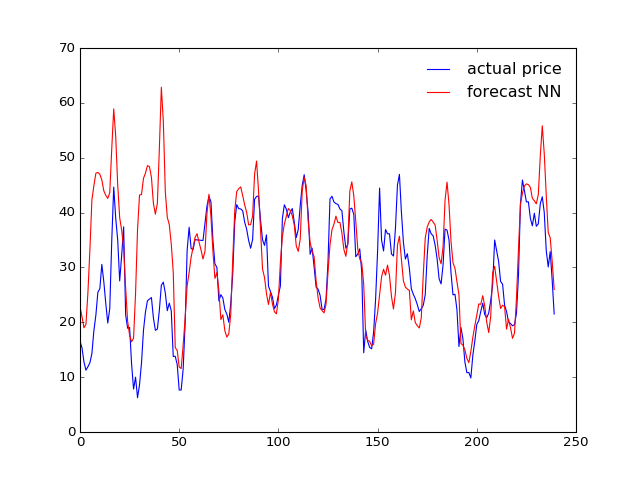

In [27]:
# Plots
plt.figure()
plt.plot(Y[:10,:].flatten(), color='blue', label='actual price')
plt.plot(predict_nn[:10,:].flatten(), color='red', label='forecast NN')
plt.legend(frameon=False)
plt.show()

# 8. Assignment: Improve the naive implementation in Step 7


* Create test and validation set
    * https://en.wikipedia.org/wiki/Test_set
    * http://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set
* Add additional features
    * same day of the previous week (see autocorrelation plot)
    * use a wind and solar forecast as an additional feature (assume you can make perfect forecasts)
* Tune the structure of the neural network
    * number of layers
        * http://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    * different activation functions
        * https://en.wikipedia.org/wiki/Activation_function

Advice: read the documentation on https://keras.io/ for help